In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime, timedelta
import corner
#Import my function library
import ipynb.fs.full.MRT_Funcs as MRT

## Portfolio Backtest

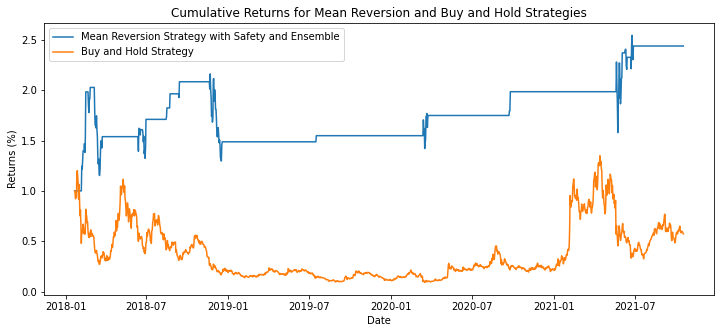

Portfolio Backtest Statistics


,strat_stats,base_stats
tot_returns,1.440,-0.519
annual_returns,0.179,-0.126
annual_volatility,0.384,1.077
max_drawdown,0.875,8.089
max_drawdown_duration,911.000,1168.000


In [31]:
#List of stocks we want to consider in our portfolio
#Cryptos valid back to 2018-01
tickers = ['ADA-CAD','BAT-CAD','BCH-CAD','BTC-CAD','DOGE-CAD','ETH-CAD','FIL-CAD','LINK-CAD','LTC-CAD','MANA-CAD','MKR-CAD','XTZ-CAD','XLM-CAD','ZRX-CAD']

verbose = False

start_date = '2017-05-01'
end_date = '2021-10-17'
strat='SMA_MR'
SMA = 40
threshold = 0.3
safety = False
safety_threshold = 0.15
short_term_sma=10
long_term_sma=30
short_long_threshold=0.05

strat_settings = [tickers, strat, SMA, threshold, safety, safety_threshold, short_term_sma, long_term_sma, short_long_threshold, start_date, end_date, verbose]
#Run the backtest on the entire portfolio
portfolio_returns, portfolio_stats = MRT.portfolioBacktest(strat_settings)
#Plot portfolio backtest returns
MRT.plot_portfolio_backtest(portfolio_returns)
#Print portfolio backtest statistics
print('Portfolio Backtest Statistics')
round(portfolio_stats,3)

## Evaluate effects of SMA and threshold

In [ ]:
#Fixed settings
verbose = False
start_date = '2017-01-01'
end_date = '2021-10-17'
strat='SMA_MR'

safety = False
#Fixed hyperparams
short_term_sma=10
long_term_sma=30
short_long_threshold=0.05
dt = 0.05
safety_threshold = threshold + dt

#Variable hyperparams
SMAs = [2,200]
thresholds = [0.01,0.7]

N = 12
SMAv = np.linspace(SMAs[0],SMAs[1],N)
thresholdv = np.linspace(thresholds[0],thresholds[1],N)
param_vecs = np.array([SMAv,thresholdv])

stat_grid = np.empty([N, N])
npts = N**2
print('Performing hyperparameter gridsearch. Grid size=',npts)
count = 0
for i1 in range(0,N):
    print(count,' of ',npts,' gridpoints')
    for i2 in range(0,N):
        count = count+1
        #Get the hyperparams for this gridpoint
        SMA = SMAv[i1]
        threshold = thresholdv[i2]
        #Run backtest and evaluate performance
        strat_settings = [tickers, strat, SMA, threshold, safety, safety_threshold, short_term_sma, long_term_sma, short_long_threshold, start_date, end_date, verbose]
        portfolio_returns, portfolio_stats = MRT.portfolioBacktest(strat_settings)
        annual_return_diff = MRT.annual_return_diff(portfolio_stats)
        #Store the result
        stat_grid[i1,i2] = annual_return_diff
print('Gridsearch completed')

## Filter & Save Results

In [ ]:
#Filter out unreasonably small, large, and negative values from the results
stat_gridc = MRT.clean_stat_grid(stat_grid, min_val=1e-5, max_val=1e2, neg_val=5)

#Save parameter vectors to csv
param_name = 'ParamEffects_sma/param_vecs_N{}.csv'.format(N)
np.savetxt(param_name, param_vecs, delimiter =", ", fmt ='% s')
#Save gridsearch output statistic vector to csv, with a header giving the array length so we can reshape it when loading it back
head = str(N)
stat_name = 'ParamEffects_sma/stat_grid_N{}.csv'.format(N)
np.savetxt(stat_name, stat_grid, delimiter =", ", header=head, fmt ='% s')

## Load Results

In [17]:
N=10
#Load parameter vectors
param_name = 'ParamEffects_sma/param_vecs_N{}.csv'.format(N)
param_vecs = np.loadtxt(param_name, delimiter =", ")
SMAs = [param_vecs[0][0], param_vecs[0][-1]]
thresholds = [param_vecs[1][0], param_vecs[1][-1]]

#Load output statistic vector
stat_name = 'ParamEffects_sma/stat_grid_N{}.csv'.format(N)
stat_grid = np.loadtxt(stat_name, delimiter =", ")

## Plot Results

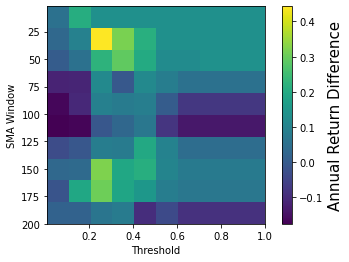

In [21]:
fig, ax = plt.subplots()
h = ax.imshow(stat_grid, extent=[thresholds[0],thresholds[1],SMAs[1],SMAs[0]])
#Can I use a colormap that distinguishes between positive and negative values?
ax.set_aspect(thresholds[1]/SMAs[1])
plt.xlabel('Threshold')
plt.ylabel('SMA Window')
cbar = fig.colorbar(h) 
cbar.set_label('Annual Return Difference',size=15)

## Evaluate effects of short-long SMA and threshold

In [ ]:
#Fixed settings
verbose = False
start_date = '2017-01-01'
end_date = '2021-10-17'
strat='SMA_MR'

safety = False
#Fixed hyperparams
SMA = 25
threshold = 0.3
dt = 0.05
safety_threshold = threshold + dt

#Variable hyperparams
shorts = [2,100] #short_term_sma
slrs = [1.5,10] #short-long ratio
slts = [0.01,1.0] #short-long threshold
#long_term_sma = int(short_term_sma*slr)

N = 4
shortv = np.linspace(shorts[0],shorts[1],N)
slrv = np.linspace(slrs[0],slrs[1],N)
sltv = np.linspace(slts[0],slts[1],N)
param_vecs = np.array([shortv,slrv,sltv])

stat_grid = np.empty([N, N, N])
npts = N**3
print('Performing hyperparameter gridsearch. Grid size=',npts)
count = 0
for i1 in range(0,N):
    print(count,' of ',npts,' gridpoints')
    for i2 in range(0,N):
        for i3 in range(0,N):
            count = count+1
            #Get the hyperparams for this gridpoint
            short_term_sma = int(shortv[i1]) #Seems like the int is handled inside of the model somewhere already since no error is thrown when I leave it out here
            long_term_sma = int(shortv[i1]*slrv[i2])
            short_long_threshold = sltv[i3]
            #Run backtest and evaluate performance
            strat_settings = [tickers, strat, SMA, threshold, safety, safety_threshold, short_term_sma, long_term_sma, short_long_threshold, start_date, end_date, verbose]
            portfolio_returns, portfolio_stats = MRT.portfolioBacktest(strat_settings)
            annual_return_diff = MRT.annual_return_diff(portfolio_stats)
            #Store the result
            stat_grid[i1,i2,i3] = annual_return_diff
print('Gridsearch completed')

## Filter & Save Results

In [ ]:
#Filter out unreasonably small, large, and negative values from the results
stat_gridc = MRT.clean_stat_grid(stat_grid, min_val=1e-5, max_val=1e2, neg_val=5)

#Save parameter vectors to csv
param_name = 'ParamEffects_sl/param_vecs_N{}.csv'.format(N)
np.savetxt(param_name, param_vecs, delimiter =", ", fmt ='% s')
#Save gridsearch output statistic vector to csv, with a header giving the array length so we can reshape it when loading it back
stat_name = 'ParamEffects_sl/stat_grid_N{}.csv'.format(N)
MRT.write_3d_nparray(stat_name)

## Load Results

In [22]:
N=4
#Load parameter vectors
param_name = 'ParamEffects_sl/param_vecs_N{}.csv'.format(N)
param_vecs = np.loadtxt(param_name, delimiter =", ") #Need to check if this is the right usage
shorts = [param_vecs[0][0], param_vecs[0][-1]]
slrs = [param_vecs[1][0], param_vecs[1][-1]]
slts = [param_vecs[2][0], param_vecs[2][-1]]
#Load output statistic vector
stat_name = 'ParamEffects_sl/stat_grid_N{}.csv'.format(N)
#stat_grid = np.loadtxt(stat_name, delimiter =", ")
stat_grid = MRT.load_3d_nparray(stat_name, N)

## Plot Results

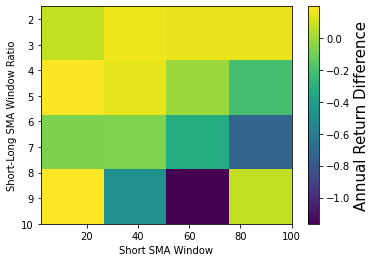

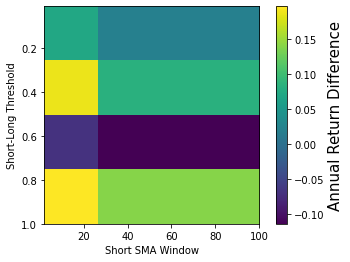

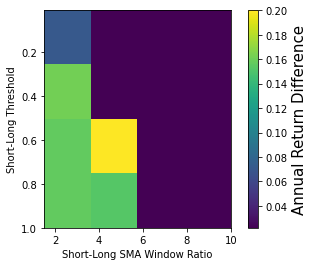

In [27]:
#Marginalize over each dimension to create three 2d stat_grids to plot

fig, ax = plt.subplots()
h=ax.imshow(stat_grid[:,:,0], extent=[shorts[0],shorts[1],slrs[1],slrs[0]]) #Replace this slice with an average over slt
#Can I use a colormap that distinguishes between positive and negative values?
ax.set_aspect(shorts[1]/slrs[1])
plt.xlabel('Short SMA Window')
plt.ylabel('Short-Long SMA Window Ratio')
cbar = fig.colorbar(h) 
cbar.set_label('Annual Return Difference',size=15)

fig, ax = plt.subplots()
h=ax.imshow(stat_grid[:,0,:], extent=[shorts[0],shorts[1],slts[1],slts[0]]) #Replace this slice with an average over slt
#Can I use a colormap that distinguishes between positive and negative values?
ax.set_aspect(shorts[1]/slts[1])
plt.xlabel('Short SMA Window')
plt.ylabel('Short-Long Threshold')
cbar = fig.colorbar(h) 
cbar.set_label('Annual Return Difference',size=15)

fig, ax = plt.subplots()
h=ax.imshow(stat_grid[0,:,:], extent=[slrs[0],slrs[1],slts[1],slts[0]]) #Replace this slice with an average over slt
#Can I use a colormap that distinguishes between positive and negative values?
ax.set_aspect(slrs[1]/slts[1])
plt.xlabel('Short-Long SMA Window Ratio')
plt.ylabel('Short-Long Threshold')
cbar = fig.colorbar(h) 
cbar.set_label('Annual Return Difference',size=15)

## Run a hyperparameter gridsearch on the portfolio

In [ ]:
tickers_g = ['BAT-CAD','BTC-CAD','ETH-CAD','CRV-CAD','ZRX-CAD']
N = 1 #Number of pts to use in each grid dimension
stat_grid, param_vecs = MRT.hyperparam_gridsearch(tickers_g, N)
stat_gridc = MRT.clean_stat_grid(stat_grid, min_val=1e-3, max_val=1e2, neg_val=5) #Filter out unreasonably small, large, and negative values from the results
MRT.save_gridsearch(param_vecs, stat_grid, N) #Save results

## Plot a histogram of the gridsearch results (annual return difference) and individual parameter plots

In [ ]:
#Histogram
npts = N**6
stat_vec = np.reshape(stat_gridc, npts) #Reshape stats into a vector so we can histogram it

f = plt.hist(stat_vec, bins=20, log='True')
#plt.xscale('log')

#Parameter plots
#stat_vecs = MRT.plot_gridsearch_results(stat_gridc, param_vecs, N) #Plot results of gridsearch averaged over each hyperparam

## Save and load gridsearch results

In [ ]:
switch = 'load'
if switch=='save':
    MRT.save_gridsearch(param_vecs, stat_gridc, N) #Save results of gridsearch
elif switch=='load':
    N=3
    param_vecs, stat_grid = MRT.load_gridsearch(N) #Load results of gridsearch

## Evaluate backtest using best hyperparams from gridsearch

In [ ]:
#Find setting combinations which exceed a given score
qualifying_score = 1.8
r = np.where(stat_gridc > qualifying_score)
print(r)

In [ ]:
#Get best hyperparams from gridsearch
#ind = np.unravel_index(np.argmax(stat_vecs, axis=None), stat_gridc.shape)
ind = [2,0,1,0,2,1]
#replace w/ r[0,0], r[1,0], etc. But not sure how to index properly with this variable (list of arrays)

SMAo = param_vecs[0][ind[0]]
thresholdo = param_vecs[1][ind[1]]
safety_thresholdo = param_vecs[2][ind[2]]
short_term_smao = param_vecs[3][ind[3]]
long_term_smao = param_vecs[4][ind[4]]
short_long_thresholdo = param_vecs[5][ind[5]]

#Strategy and dates used for gridsearch
tickers_g = ['BAT-CAD','BTC-CAD','ETH-CAD','CRV-CAD','ZRX-CAD']
start_date = '2018-05-01'
end_date = '2021-10-17'
strat='SMA_MR'
verbose = False
safety = True

#Run backtest using best hyperparams from gridsearch
strat_settings_o = [tickers_g, strat, SMAo, thresholdo, safety, safety_thresholdo, short_term_smao, long_term_smao, short_long_thresholdo, start_date, end_date, verbose]
#Run the backtest on the entire portfolio
portfolio_returns_o, portfolio_stats_o = MRT.portfolioBacktest(strat_settings_o)
#Plot portfolio backtest returns
MRT.plot_portfolio_backtest(portfolio_returns_o)
#Print portfolio backtest statistics
print('Portfolio Backtest Statistics')
round(portfolio_stats_o,3)